In [47]:
!pip install pytickersymbols
!pip install pandas_datareader 


In [1]:
import numpy as np
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16, 9)
import scipy.optimize
from pandas_datareader import data as web
import yfinance as yf
import statistics
import random
# from pandas_datareader import data

# import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier


Some helper functions

In [2]:
def port_mean(R,W):
    return np.sum(R*W)

def port_var(W,C):
    return np.dot(np.dot(W,C), W)

In [3]:
class Result:
    def __init__(self, W, tangent_mean, tangent_var, frontier_mean, frontier_var, frontier_weights):
        self.W=W
        self.tangent_mean=tangent_mean
        self.tangent_var=tangent_var
        self.frontier_mean=frontier_mean
        self.frontier_var=frontier_var
        self.frontier_weights=frontier_weights

In [4]:
def optimize_weights(R,C,rf):
    # utility function which we have to optimize
    def util_function(W,R,C,rf):
        mean = port_mean(R,W)
        var = port_var(W,C)
        util = (mean - rf) / np.sqrt(var)
        return 1/util

    n = len(R)
    W = np.ones(n)/n # initialize weights with equal values
    bound = [(0.,1.) for i in range(n)]  #defining bounds for weights
    print("x")
    constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1.}] #constraint for weights
    print("y")

    optimized_weights = scipy.optimize.minimize(util_function, W, (R,C,rf), method='SLSQP', constraints=constraint, bounds=bound)
    if not optimized_weights.success: raise BaseException(optimized_weights.message)
    return optimized_weights.x


In [5]:
# for different returns we will find optimal weights and mean, variance 
# which will help in plotting graph
def optimize_frontier(R,C,rf):
    # utility function for a particular return 
    def util_function(W,R,C,r):
        mean = port_mean(R,W)
        var = port_var(W,C)
        penalty = 100 * abs(mean-r)
        return var + penalty

    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)

    for r in np.linspace(min(R), max(R), num=30):
        W = np.ones(n)/n
        bound = [(0.,1.) for i in range(n)]  #defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1.}] #constraint for weights

        optimized_weights = scipy.optimize.minimize(util_function, W, (R,C,r), method='SLSQP', constraints=constraint,  bounds=bound)
        
        if not optimized_weights.success: raise BaseException(optimized_weights.message)

        frontier_weights.append(optimized_weights.x)
        frontier_means.append(r)
        frontier_vars.append(port_var(optimized_weights.x, C))

    return np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights)


In [6]:
def efficient_frontier_class(R,C,rf):
    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)


    max_value = -10

    R = np.asarray(R)
    
    mu_one = np.c_[ R, np.ones(n) ]

    middle_term = np.linalg.inv( np.dot(np.dot(mu_one.T, np.linalg.inv(C)), mu_one) )

    for r in np.linspace(min(R), max(R), num=30):
        exp_return_term = np.array([r,1])
    
        weights = np.dot( np.dot( np.dot( np.linalg.inv(C), mu_one), middle_term ), exp_return_term.T)
        frontier_weights.append(weights);
        frontier_means.append(r)
        var = port_var(weights, C)
        frontier_vars.append(var)

        sharpe_ratio = (r - rf) / np.sqrt(var)
        if(sharpe_ratio > max_value):
            max_value = sharpe_ratio
            tangent_mean = r
            tangent_var = var
            tangent_weights = weights



        # var_mid_term = np.dot(np.dot(mu_one.T, np.linalg.inv(C)), mu_one)
        # var = np.dot(np.dot(exp_return_term, var_mid_term), exp_return_term.T)
        # frontier_vars.append(var)

        # frontier_means.append(r)

    return Result(tangent_weights, tangent_mean, tangent_var, np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights) )




In [7]:
def new_efficient_frontier_class(R,C,rf):

    def util_function(C,W,r, mu_one, lamda, gamma):
        exp_return_term = np.array([r,1])
        lagrangians = np.array([lamda, gamma]).T

        first_term = np.dot(np.dot(W.T, C), W)
        second_term = np.dot( exp_return_term - np.dot(W.T, mu_one), lagrangians)

        return first_term + second_term



    frontier_means = []
    frontier_vars = []
    frontier_weights = []
    n = len(R)


    max_value = -10

    R = np.asarray(R)
    
    mu_one = np.c_[ R, np.ones(n) ]

    # middle_term = np.linalg.inv( np.dot(np.dot(mu_one.T, np.linalg.inv(C)), mu_one) )

    for r in np.linspace(min(R), max(R), num=30):
        W = np.ones(n)/n
        lamda = np.random.randint(1,10)
        gamma = np.random.randint(1,10)
        bound = [(0.,1.) for i in range(n)]  #defining bounds for weights
        constraint = [{'type': 'eq', 'fun': lambda W: np.sum(W)-1.}] #constraint for weights

        optimized_weights = scipy.optimize.minimize(util_function, (W, lamda, gamma), (C,r,mu_one), method='SLSQP', constraints=constraint,  bounds=bound)
        
        if not optimized_weights.success: raise BaseException(optimized_weights.message)

        frontier_weights.append(optimized_weights.x)
        frontier_means.append(r)
        var = port_var(optimized_weights.x, C)
        frontier_vars.append()

        sharpe_ratio = (r - rf) / np.sqrt(var)
        if(sharpe_ratio > max_value):
            max_value = sharpe_ratio
            tangent_mean = r
            tangent_var = var
            tangent_weights = optimized_weights.x



        # var_mid_term = np.dot(np.dot(mu_one.T, np.linalg.inv(C)), mu_one)
        # var = np.dot(np.dot(exp_return_term, var_mid_term), exp_return_term.T)
        # frontier_vars.append(var)

        # frontier_means.append(r)

    return Result(tangent_weights, tangent_mean, tangent_var, np.array(frontier_means), np.array(frontier_vars), np.array(frontier_weights) )




Load Data

In [8]:
from pytickersymbols import PyTickerSymbols
stock_data = PyTickerSymbols()
stocks_list = stock_data.get_dow_jones_nyc_yahoo_tickers()
stocks_list.remove('DOW')
len(stocks_list)


30

In [9]:
tickers = yf.Tickers(stocks_list)
market_cap = {}
for str in stocks_list:
    market_cap[str] = tickers.tickers[str].info['marketCap']
# market_cap

In [10]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations
def load_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('dow-jones/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-2000:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(market_cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
# print(prices)
prices = np.array(prices)

## Historical Returns

In [11]:
def historical_returns(prices):
    prices = pd.DataFrame(prices).T
    returns = prices.pct_change()
    cov_mat = returns.cov() * 252

    # expected_returns = np.array([])
    individual_returns = ((1 + np.mean(returns, axis=0)) ** 252)-1

    return np.array(individual_returns), np.array(cov_mat)

W = np.array(caps) / sum(caps) # calculate market weights from capitalizations
# R1, C1 = historical_returns(prices)
R, C = historical_returns(prices)
rf = .035  # Risk-free rate


In [12]:
def get_frontier(R, C, rf):
    W = optimize_weights(R, C, rf)
    tangent_mean = port_mean(R, W)
    tangent_var = port_var(W, C)
    frontier_means, frontier_vars, frontier_weights = optimize_frontier(R, C, rf)
    return Result(W, tangent_mean, tangent_var, frontier_means, frontier_vars, frontier_weights)

In [13]:
# result1 = get_frontier(R, C, rf)
result1 = efficient_frontier_class(R,C,rf)
n = len(R)
result1.frontier_var

array([0.0097644 , 0.00964118, 0.009573  , 0.00955984, 0.00960171,
       0.00969862, 0.00985055, 0.01005752, 0.01031952, 0.01063655,
       0.01100861, 0.0114357 , 0.01191783, 0.01245498, 0.01304717,
       0.01369438, 0.01439663, 0.01515391, 0.01596622, 0.01683356,
       0.01775593, 0.01873333, 0.01976577, 0.02085323, 0.02199573,
       0.02319326, 0.02444581, 0.0257534 , 0.02711602, 0.02853368])

In [14]:
def display_assets(names, R, C, color='black'):
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result: Result, label=None, color='black'):
    from collections import defaultdict
    from IPython.core.display import HTML
    plt.text(result.tangent_var ** .5, result.tangent_mean, ' tangent', verticalalignment='center', color=color)
    plt.scatter(result.tangent_var ** .5, result.tangent_mean, marker='o', color=color), plt.grid(True)
    plt.plot(list(result.frontier_var ** .5), list(result.frontier_mean), label=label, color=color), plt.grid(True)  # draw efficient frontie

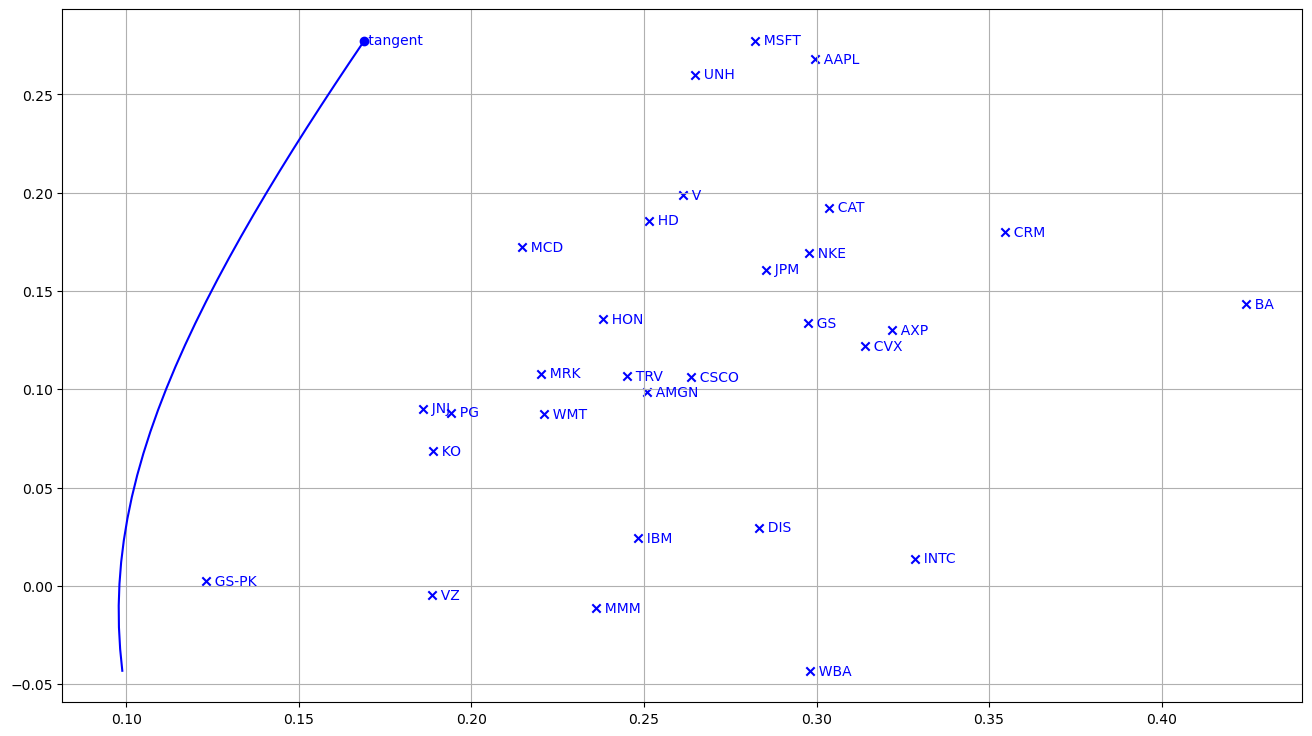

In [15]:
display_assets(names, R, C, color='blue')
display_frontier(result1, color='blue')

In [16]:
def load_stock_data(name):
    dataframe = pd.read_csv('dow-jones/%s.csv' % name, index_col=None, parse_dates=['date'])
    prices = list(dataframe['close'])[-2000:] # trailing window 500 days
    return prices

In [17]:
def market_return(prices):
    prices = np.matrix(prices)  # create numpy matrix from prices
    rows, cols = prices.shape
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    var = statistics.variance(returns[0]) * 250
    
    market_return = ((1 + np.mean(returns[0])) ** 250) - 1
  
    return market_return, var

In [18]:
def cov_matrix(stock_prices, spy_prices):
    
    prices_df = pd.DataFrame(prices)
    asset_returns = prices_df.pct_change()
    asset_returns.drop(columns=asset_returns.columns[0], axis=0, inplace=True)

    spy_df = pd.DataFrame(spy_prices).T
    spy_returns = spy_df.pct_change()
    spy_returns.drop(columns=spy_returns.columns[0], axis=1, inplace=True)

    
    print('Asset returns', asset_returns.shape)
    print('Spy Return', spy_returns.shape)


    cov_matrix = []
    for r in range(stock_prices.shape[0]):
        covar = np.cov(asset_returns[r+1], spy_returns)[0,1]
        cov_matrix.append(covar)

    var_spy = np.cov(spy_returns,spy_returns)[0,0]

    print(cov_matrix)
    print(var_spy)

    return (np.asarray(cov_matrix) * 250) / var_spy

In [19]:
spy_prices = load_stock_data('SPY')
rm, market_var = market_return(spy_prices)

## Black-litterman reverse optimization

In [45]:
# Calculate portfolio historical return and variance
mean = port_mean(R, W)
var = port_var(W,C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns
print(Pi, R)

[0.11277747 0.16278477 0.20432273 0.18886099 0.13775823 0.13766637
 0.14897301 0.08746181 0.03836485 0.16018284 0.13983193 0.12036467
 0.17523799 0.08539939 0.15054211 0.10294032 0.14577277 0.08827086
 0.19502549 0.08858469 0.10973282 0.13287184 0.06660796 0.16020669
 0.08064652 0.1158481  0.13695897 0.11271397 0.13345574 0.18376174] [-0.01139749  0.12995906  0.26771352  0.14330435  0.19238213  0.12186442
  0.10622025  0.06863905  0.00242946  0.13351046  0.18575797  0.02421168
  0.01385409  0.09013986  0.16080835  0.17237675  0.16905813  0.10793506
  0.27721477  0.08804824  0.10664208  0.25998061 -0.00486174  0.19883916
  0.08740008 -0.04320811  0.02958325  0.0985969   0.13577698  0.17975741]


[]

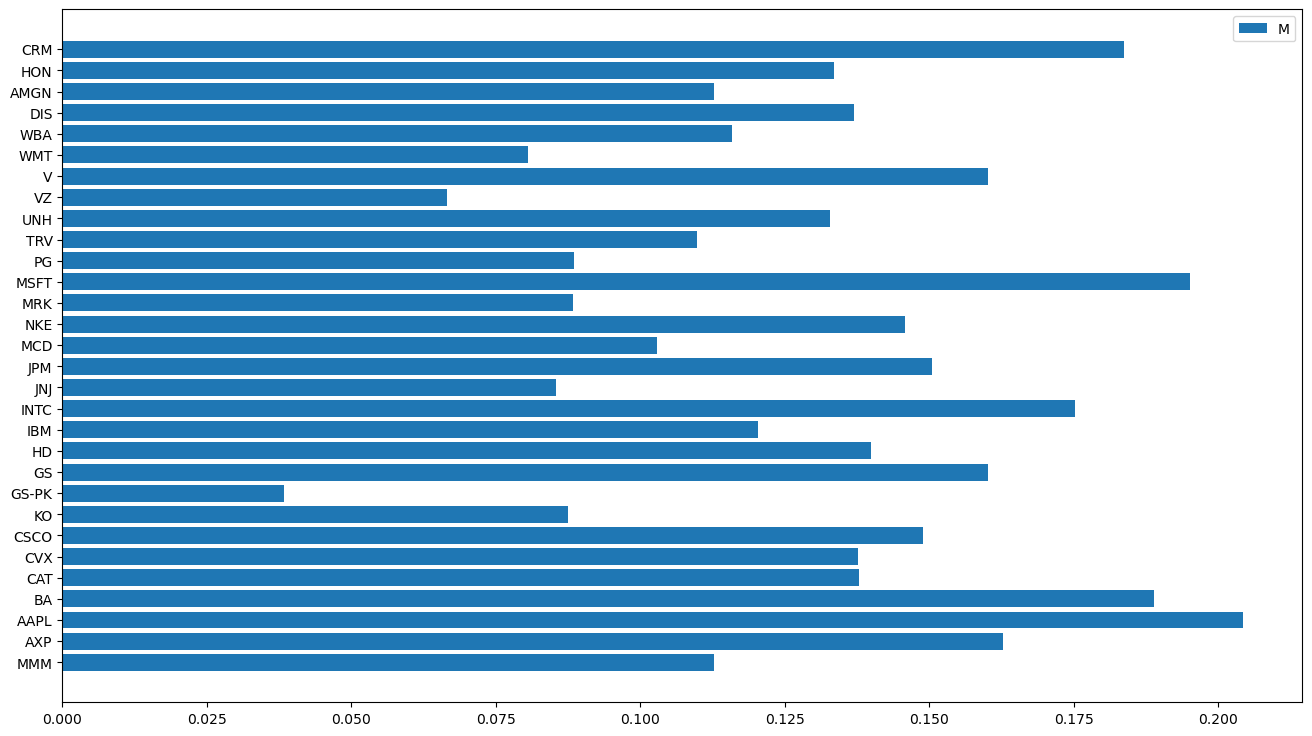

In [46]:
plt.barh(stocks_list, Pi)
plt.legend('Min '+ stocks_list[ np.argmin(Pi)])
plt.plot()

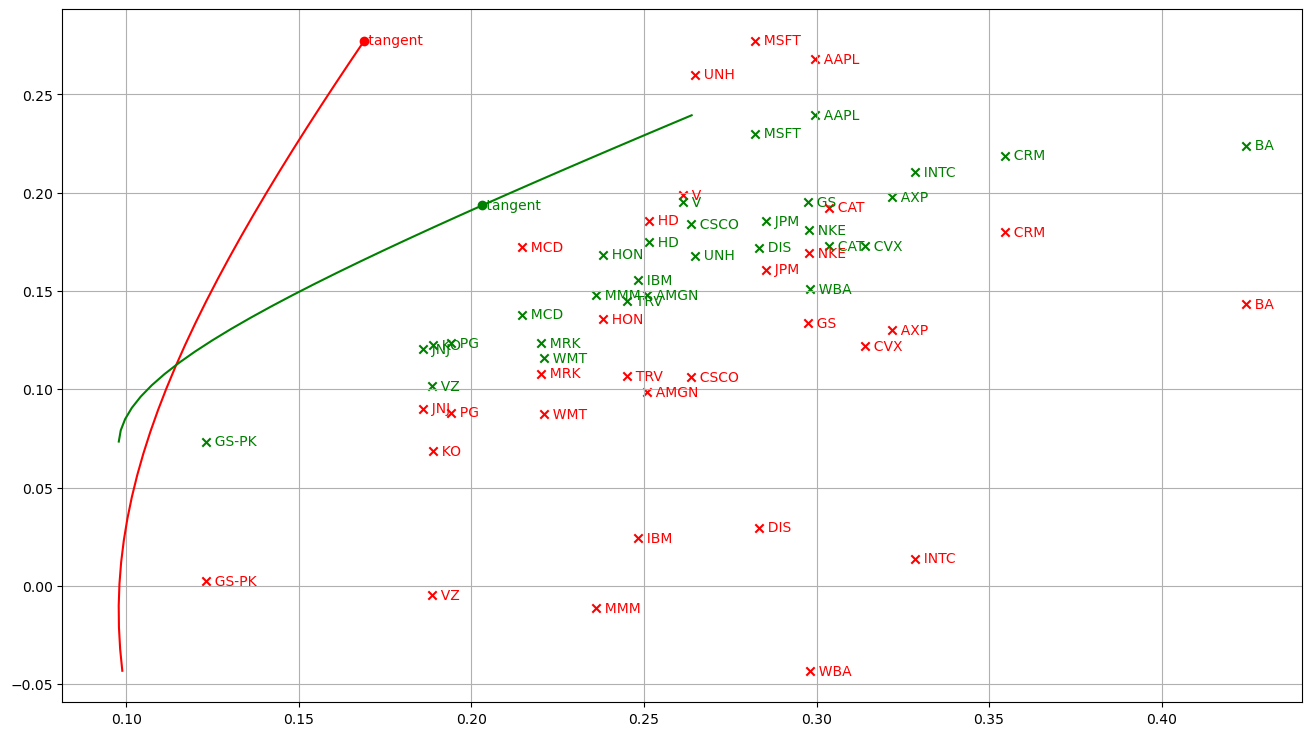

In [21]:
# result2 = get_frontier(Pi+rf, C, rf)
result2 = efficient_frontier_class(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(result1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(result2, label='Implied returns', color='green')

##### Determine views to the equilibrium returns and prepare views (Q) and link (P) matrices

In [22]:
def load_latest_data():
    symbols = stocks_list
    n = len(symbols)
    prices_out = []
    for s in symbols:
        dataframe = pd.read_csv('dow-data-23/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close']) 
        prices_out.append(prices)
    return  prices_out

latest_prices = load_latest_data()
# print(prices)

In [23]:
def get_absolute_views(latest_prices):
    latest_prices = pd.DataFrame(latest_prices).T
    latest_prices = latest_prices.pct_change()
    views_returns = ((1 + np.mean(latest_prices, axis=0)) ** 252)-1

    absolute_views = []
    for i in range(len(views_returns)):
        absolute_views.append((stocks_list[i], views_returns[i]))

    return absolute_views


In [24]:
absolute_views = get_absolute_views(latest_prices)

In [25]:
def create_views_and_link_matrix(names, relative_views, absolute_views):
    r, a, c = len(relative_views), len(absolute_views), len(names)
    Q = [relative_views[i][3] for i in range(r)]  # view matrix
    if(absolute_views):
        for i in absolute_views:
            Q.append(i[1]);
    P = np.zeros([r+a, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(relative_views):
        name1, name2 = relative_views[i][0], relative_views[i][2]
        P[i, nameToIndex[name1]] = +1 if relative_views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if relative_views[i][1] == '>' else +1
    for i, v in enumerate(absolute_views):
        name  = absolute_views[i][0]
        P[i+r, nameToIndex[name]] += 1
    return np.array(Q), P

    

relative_views = [('AAPL', '>', 'MSFT', 0.01)]

absolute_views_1 = [ 
                    ('AAPL', 0.22),
                    ('CRM', 0.17),
                    ('DIS', 0.28),
                    ('GS', 0.24),
                    ('JNJ', -0.1),
                    ('JPM', 0.17),
                    ('MRK', 0.12),
                    ('MSFT', 0.23),
                    ('PG', 0.054),
                    ('UNH', 0.164),
                    ('V', 0.19)
                    ]


Q, P = create_views_and_link_matrix(names, relative_views, absolute_views_1)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
P = pd.DataFrame(P)
P.columns = stocks_list
display(P)

Views Matrix


,Views
0,0.010
1,0.220
2,0.170
3,0.280
4,0.240
5,-0.100
6,0.170
7,0.120
8,0.230
9,0.054


Link Matrix


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
Pi

array([0.11277747, 0.16278477, 0.20432273, 0.18886099, 0.13775823,
       0.13766637, 0.14897301, 0.08746181, 0.03836485, 0.16018284,
       0.13983193, 0.12036467, 0.17523799, 0.08539939, 0.15054211,
       0.10294032, 0.14577277, 0.08827086, 0.19502549, 0.08858469,
       0.10973282, 0.13287184, 0.06660796, 0.16020669, 0.08064652,
       0.1158481 , 0.13695897, 0.11271397, 0.13345574, 0.18376174])

In [49]:
tau = 0.025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.025 * P * C * transpose(P)
print(omega[0])


# rows,cols = omega.shape
# for r in range(rows):
#     for c in range(cols):
#         omega[r,c] = random.choice(range(90, 100))/1000
# print(omega)
# omega = np.ones(omega.shape)/11
# Calculate equilibrium excess returns with views incorporated
sub_a = np.linalg.inv(np.dot(tau, C))  #(tau.C) inverse
sub_b = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)  # (P^T.omega^-1).P
sub_c = np.dot(np.linalg.inv(np.dot(tau, C)), Pi)  # ((Tau.C)^-1).Pi
sub_d = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)   # (P^T.omega^-1).Q
Pi_adj = np.dot(np.linalg.inv(sub_a + sub_b), (sub_c + sub_d))   


# result3 = get_frontier(Pi_adj + rf, C, rf)
result3 = efficient_frontier_class(Pi_adj+rf , C, rf)
result3.W

[ 1.23839134e-03  7.46312017e-04 -1.80565169e-04 -9.81068228e-06
  2.67495815e-05 -4.46446453e-05 -1.44607586e-05 -7.22161454e-05
 -4.92079319e-04 -4.84351649e-05 -2.94566467e-05 -7.66039297e-05]


array([ 0.04380616, -0.04885387, -0.15084013, -0.04688609,  0.06105693,
       -0.0644093 , -0.00345906,  0.05840203,  0.71417161,  0.016889  ,
       -0.04552144,  0.00989502,  0.00450231,  0.07801649,  0.01758304,
        0.02146466, -0.01993484,  0.01324908,  0.03326674,  0.04806143,
       -0.00104057, -0.03443667,  0.11088363,  0.01817534,  0.10808876,
        0.02363653,  0.02252544,  0.00722653, -0.03192948,  0.03641072])

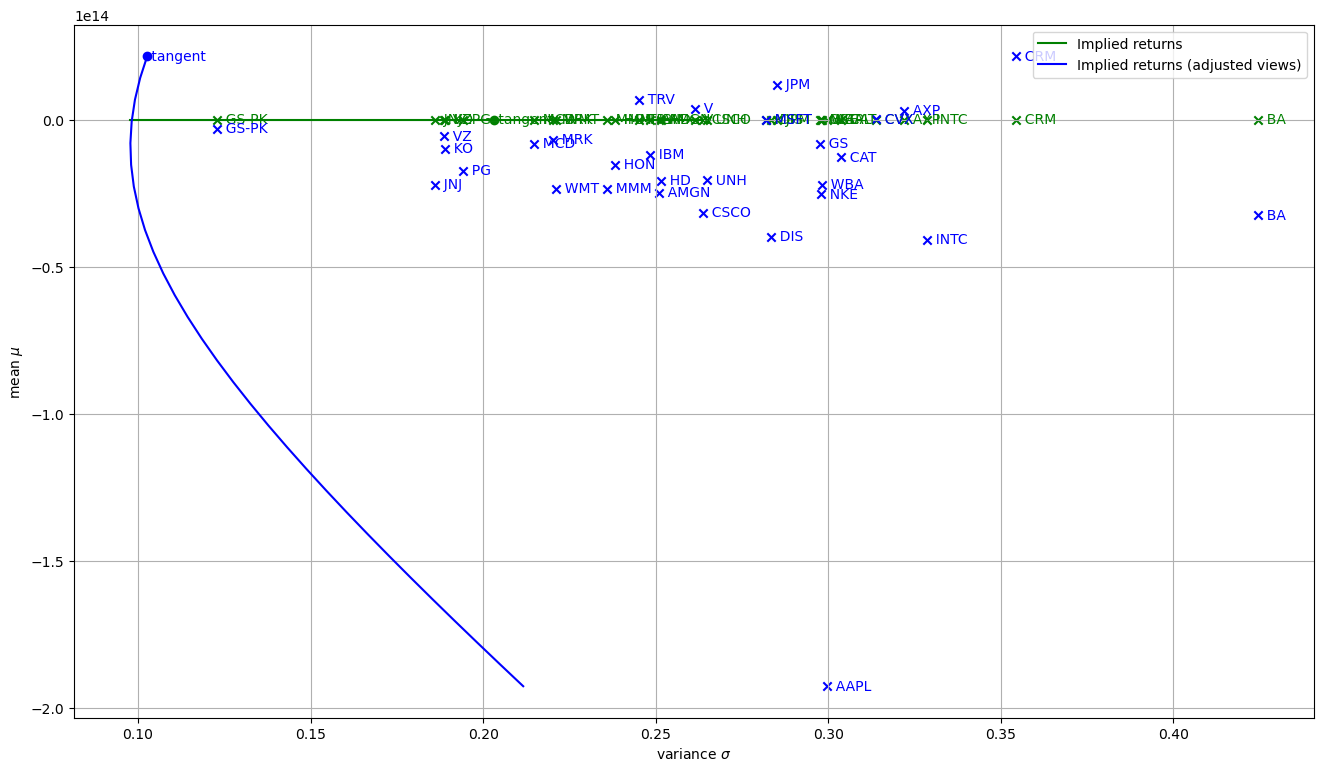

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.005108,0.009923,0.247058,0.010861,0.00989,0.026834,0.01731,0.025186,0.006897,0.00973,...,0.003827,0.041337,0.014494,0.043818,0.03754,0.002504,0.016737,0.011333,0.011838,0.018172


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,GS-PK,GS,...,TRV,UNH,VZ,V,WMT,WBA,DIS,AMGN,HON,CRM
Weight,0.043806,-0.048854,-0.15084,-0.046886,0.061057,-0.064409,-0.003459,0.058402,0.714172,0.016889,...,-0.001041,-0.034437,0.110884,0.018175,0.108089,0.023637,0.022525,0.007227,-0.031929,0.036411


In [28]:
# display_assets(names, R, C, color='red')
# display_frontier(result1, label='Historic returns', color='red')

display_assets(names, Pi+rf, C, color='green')
display_frontier(result2, label='Implied returns', color='green')

display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(result3, label='Implied returns (adjusted views)', color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()

# display(pd.DataFrame({'Weight': W}, index=names).T)

display(pd.DataFrame({'Weight': result2.W}, index=names).T)
display(pd.DataFrame({'Weight': result3.W}, index=names).T)


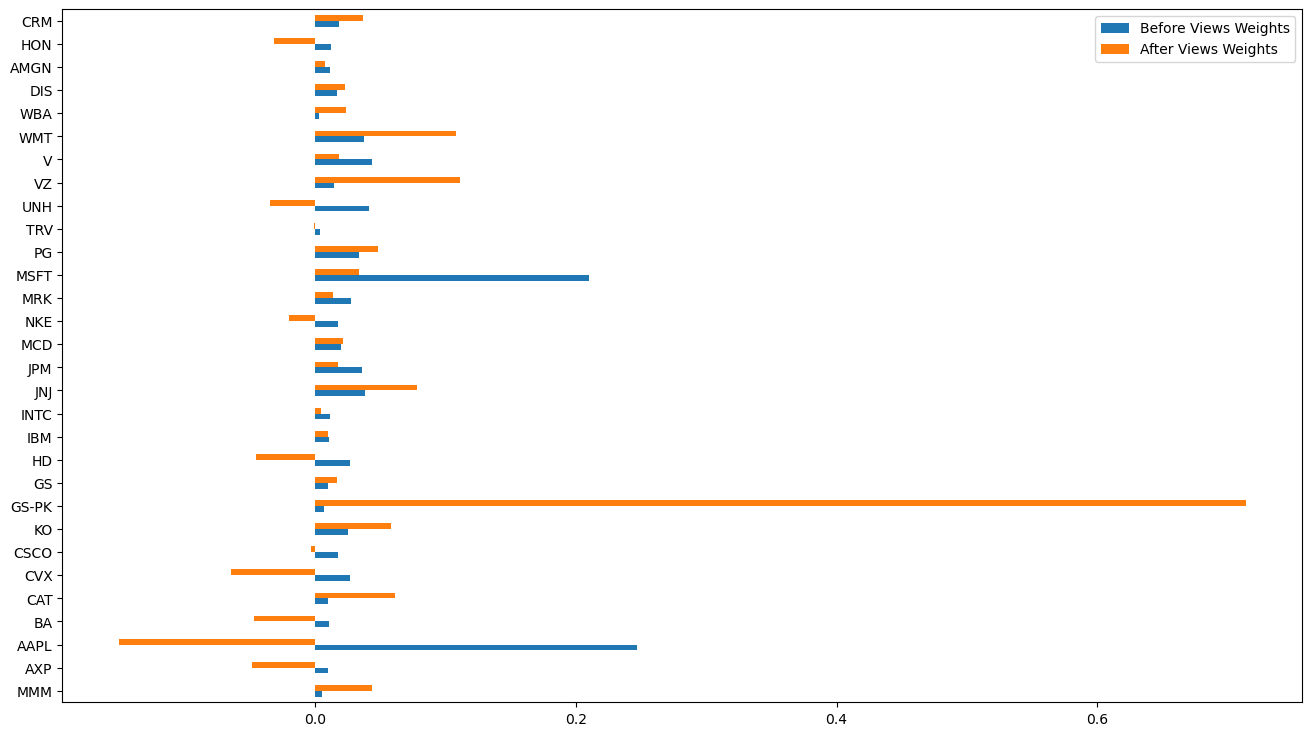

In [41]:
df = pd.DataFrame({'Before Views Weights': result2.W, 'After Views Weights ': result3.W}, index=stocks_list)
ax = df.plot.barh()

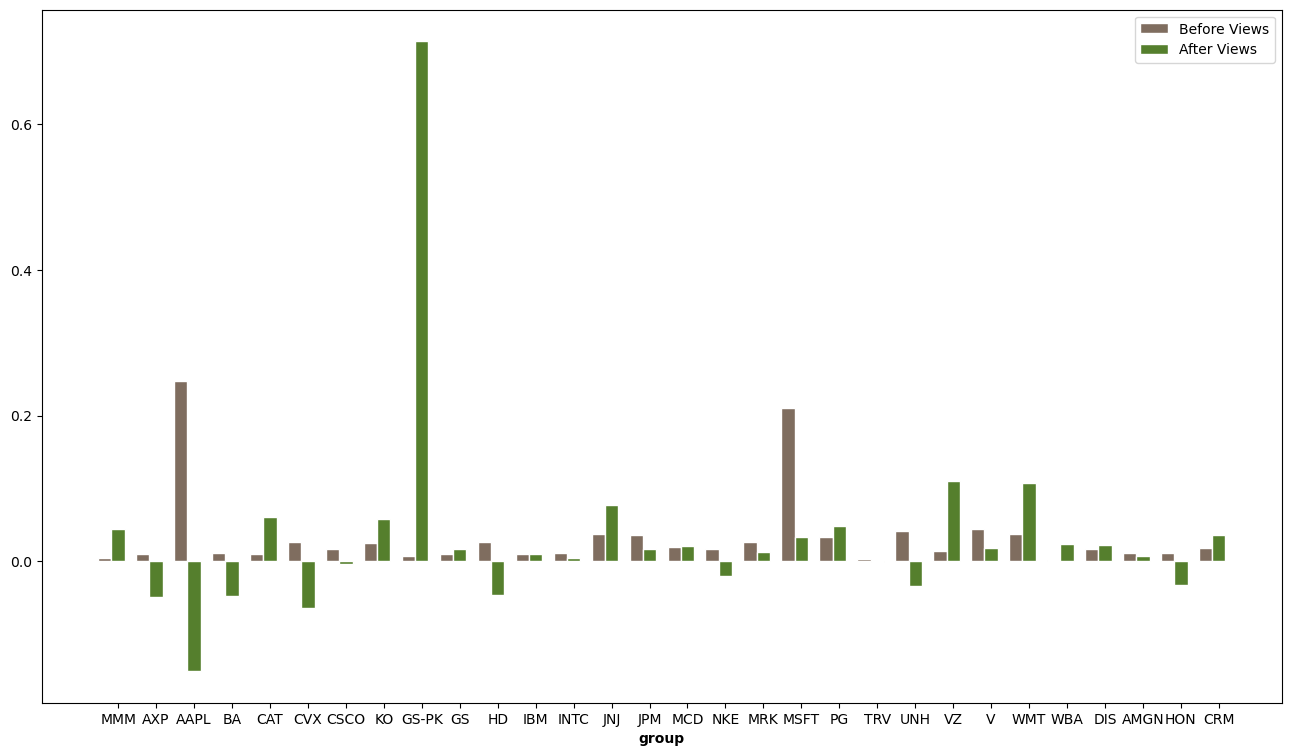

In [40]:
# set width of bars
barWidth = 0.35

 
# Set position of bar on X axis
r1 = np.arange(30)
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, result2.W, color='#7f6d5f', width=barWidth, edgecolor='white', label='Before Views')
plt.bar(r2, result3.W, color='#557f2d', width=barWidth, edgecolor='white', label='After Views')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(30)], stocks_list)
 
# Create legend & Show graphic
plt.legend()
plt.show()

[]

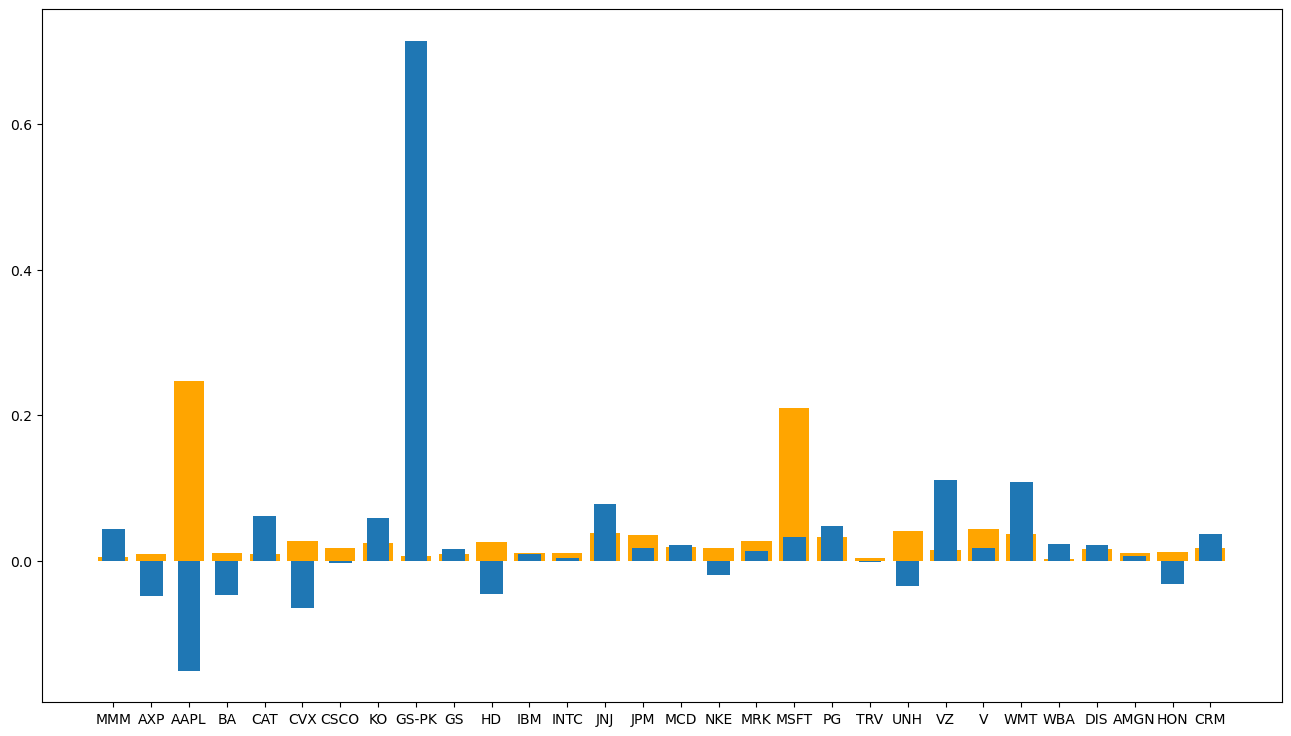

In [36]:
plt.bar(stocks_list, result2.W, color='orange')
plt.bar(stocks_list, result3.W, width=0.6)
plt.plot()

ValueError: Wedge sizes 'x' must be non negative values

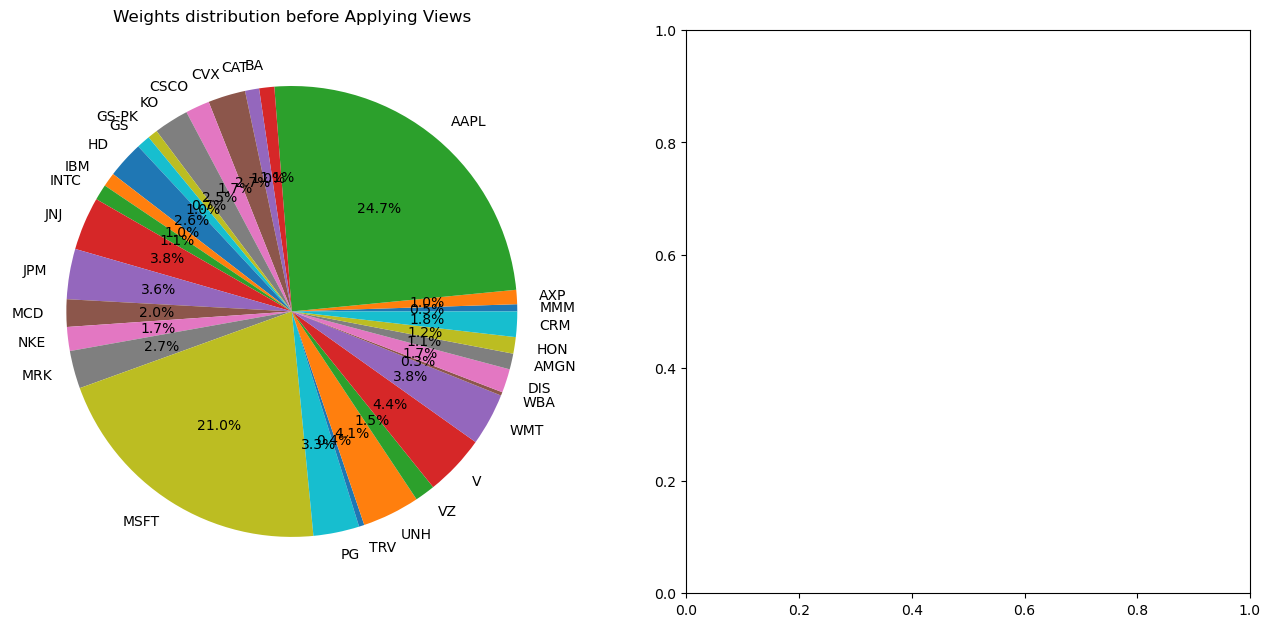

In [485]:
labels = stocks_list
pre_weights = result2.W
post_weights = result3.W
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# ...
axs[0].pie(pre_weights,labels = labels, autopct = '%1.1f%%')
axs[0].set_title('Weights distribution before Applying Views')
# ...
axs[1].pie(post_weights,labels = labels, autopct = '%1.1f%%')
axs[1].set_title('Posterior Weights after Applying Views')